# Exercise 2

Assume the aperture requires a beam size $10\ \sigma<31.4$ mm. Start with the lattice from Exercise 1 and modify it so that the $\beta_{max}$ satisfies this requirement (please use rounded numbers for convenience). The normalized beam emittance is $\epsilon_n = 2.0\ \mu$m. The circumference and the energy must not be changed, all other parameters may be modified.

In [375]:
import numpy as np #NOTE: NAFFLIB requires downgrade of numpy version. Use pip install numpy==2.0.2
import matplotlib.pyplot as plt
import pandas as pd
import xobjects as xo
import xtrack as xt
import scipy

How can we change $\beta_{max}$?

/tmp/ipykernel_227219/1929075702.py:10: RuntimeWarning: invalid value encountered in sqrt
  return 2*f*np.sqrt(4*f+L)/np.sqrt(4*f-L)


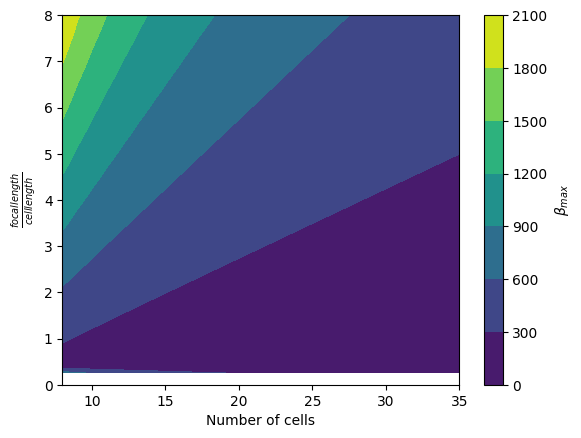

In [376]:
flr = np.linspace(0.00, 8, 64)
ls = np.linspace(0, 1000/8, 64)
ns = np.linspace(8,35, 35-8)

circ = 1000


def fun(flr, L):
    f = flr*L    
    return 2*f*np.sqrt(4*f+L)/np.sqrt(4*f-L)

def isStab(flr, L):
    f = flr*L
    return np.logical_and(L/(2*f)>0, L/(2*f)<1)

fin, lin = np.meshgrid(flr, ls)
fin, nin = np.meshgrid(flr, ns)

plt.contourf(ns, flr, fun(fin, circ/nin).T)
plt.ylabel(r'$\frac{focal length}{cell length}$')
plt.xlabel('Number of cells')
plt.colorbar(label = r'$\beta_{max}$')

#print(isStab(fin, lin))

We find that at a small number of cells, we need to reduce the focal length of the quads to reduce the max. beta-function. This is problematic - not only will run into the limits of physically achievable magnet gradients, but we will struggle to find stable optics. To give us more freedom on the focal length of the magnets we must increase the number of cells.

## Define new version of the lattice
Here we increase the number of cells to achieve the reduced $\beta_{max}$.

In [377]:
lcirc = 1000.0
lquad = 3.0
lbend = 5.0
max_dipole_field = 3.0
number_of_FODO = 20
number_of_dipoles = 4*number_of_FODO
k1 = 0.0098
pc_GeV = 20.0
lFODO = lcirc/number_of_FODO

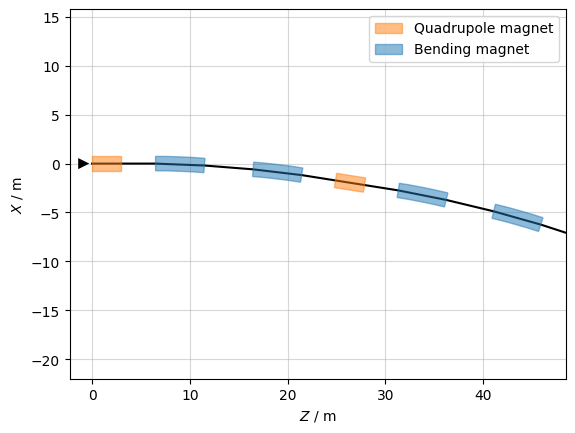

In [419]:
env = xt.Environment()
env.vars({'lcirc': lcirc,
          'lquad': lquad, 
          'lbend': lbend, 
          'k1f': k1, 
          'k1d': -k1,
          'number_of_dipoles': number_of_dipoles,
          'angle.mb': 2.0*np.pi/number_of_dipoles,
          'k0.mb': 'angle.mb/lbend',
          'number_of_fodo': number_of_FODO,
          'lfodo': 'lcirc/number_of_fodo'
          })

env.particle_ref = xt.Particles(p0c=20e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)

env.new('mb', xt.Bend, length='lbend', k0='k0.mb', h='k0.mb')
env.new('mq', xt.Quadrupole, length='lquad')

env.new('mq.f', 'mq', k1='k1f')
env.new('mq.d', 'mq', k1='k1d')

cell = env.new_line(components=[
    env.place('mq.f', at=lquad*0.5),
    env.place('mb', at='0.15 * lfodo + lquad * 0.5'),
    env.place('mb', at='0.35 * lfodo  + lquad*0.5'),
    env.place('mq.d', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb', at='0.65 * lfodo + lquad*0.5'),
    env.place('mb', at='0.85 * lfodo + lquad*0.5'),
    env.new('marker_end', xt.Marker, at='lfodo'),

])

#verify cell looks sensible
cell.survey().plot()

In [420]:
cell.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Quadrupole,mq.f,True,False,None,False,"Quadrupole(k1=0.0098, k1s=0, length=3, num_mul..."
1,3.0,Drift,drift_1,True,False,None,False,Drift(length=3.5)
2,6.5,Bend,mb,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
3,11.5,Drift,drift_2,True,False,None,False,Drift(length=5)
4,16.5,Bend,mb,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
5,21.5,Drift,drift_3,True,False,None,False,Drift(length=3.5)
6,25.0,Quadrupole,mq.d,True,False,None,False,"Quadrupole(k1=-0.0098, k1s=0, length=3, num_mu..."
7,28.0,Drift,drift_4,True,False,None,False,Drift(length=3.5)
8,31.5,Bend,mb,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
9,36.5,Drift,drift_5,True,False,None,False,Drift(length=5)


In [421]:

cells = []
for i in range(number_of_FODO):
    cells.append(env.new('cell_{}'.format(i), cell))


#%% append in cells number_of_FODO times cell
line = env.new_line(components=[env.new('_start_point', xt.Marker)]+cells)

line.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,_start_point,False,False,None,False,Marker(_dummy=np.int64(0))
1,0.0,Quadrupole,mq.f.cell_0,True,False,None,False,"Quadrupole(k1=0.0098, k1s=0, length=3, num_mul..."
2,3.0,Drift,drift_1.cell_0,True,False,None,False,Drift(length=3.5)
3,6.5,Bend,mb.cell_0,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
4,11.5,Drift,drift_2.cell_0,True,False,None,False,Drift(length=5)
...,...,...,...,...,...,...,...,...
257,986.5,Drift,drift_5.cell_19,True,False,None,False,Drift(length=5)
258,991.5,Bend,mb.cell_19,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
259,996.5,Drift,drift_6.cell_19,True,False,None,False,Drift(length=3.5)
260,1000.0,Marker,marker_end.cell_19,False,False,None,False,Marker(_dummy=np.int64(0))


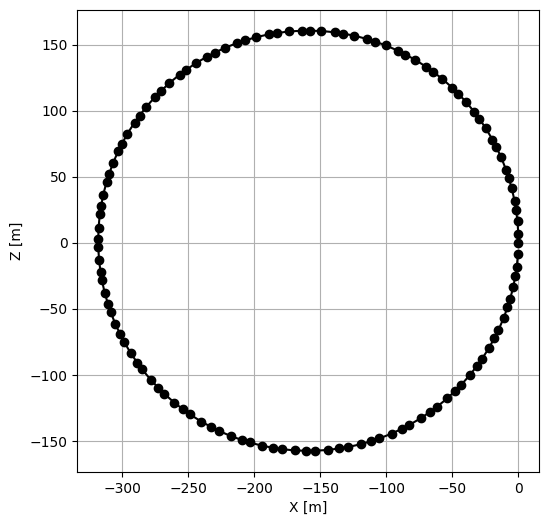

In [422]:
# 2. Definition of the beam
line.particle_ref = xt.Particles(p0c=20e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)
# %%
context = xo.ContextCpu()
line.build_tracker(_context=context)

#%%
mySurvey = line.survey()
mySurvey = mySurvey.rows[r'^(mq|mb).*']
fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(mySurvey.X, mySurvey.Z, 'o-', label="x", c="k")
plt.axis('square')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()
# %%
myTwiss= line.twiss(method='4d')

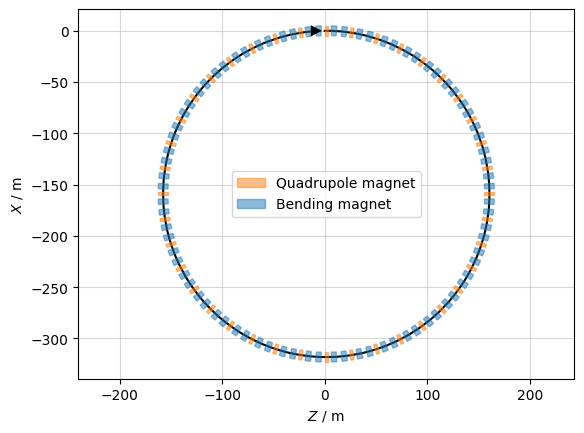

In [423]:
mySurvey.plot()

## Inspect Twiss/Courant-Snyder parameters of lattice

(-0.05, 0.05)

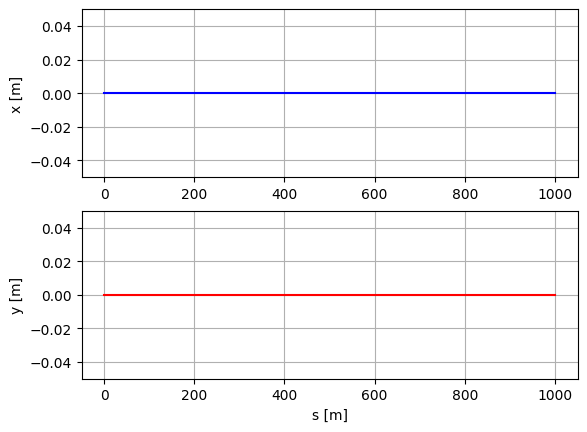

In [424]:
# The closed orbit corresponds in this case to the reference orbit
plt.subplot(211)
plt.plot(myTwiss.s,myTwiss.x,'b',label='x')
plt.ylabel('x [m]')
plt.grid()
plt.ylim(-0.05,0.05)

plt.subplot(212)
plt.plot(myTwiss.s,myTwiss.y,'r',label='y')
plt.xlabel('s [m]')
plt.ylabel('y [m]')
plt.grid()
plt.ylim(-0.05,0.05)

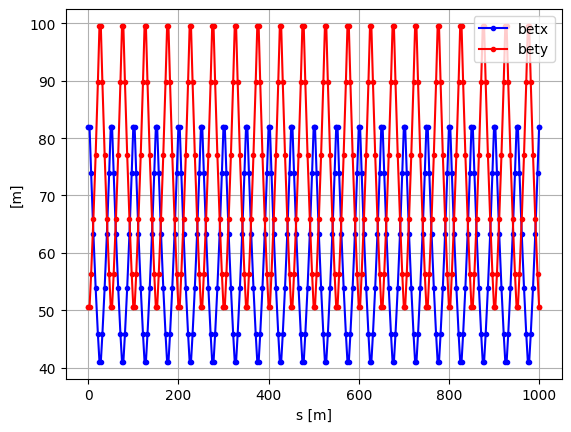

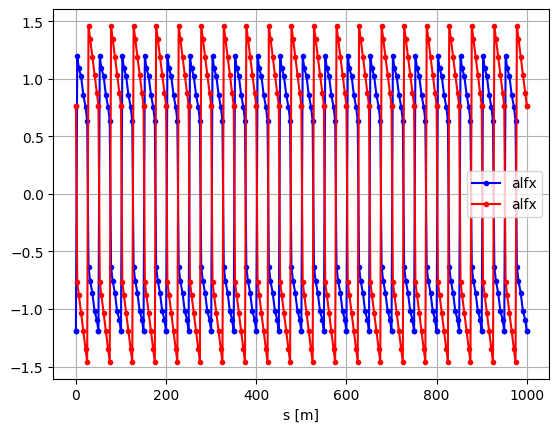

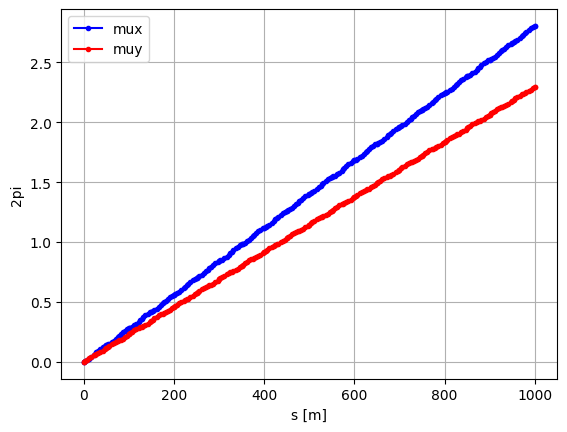

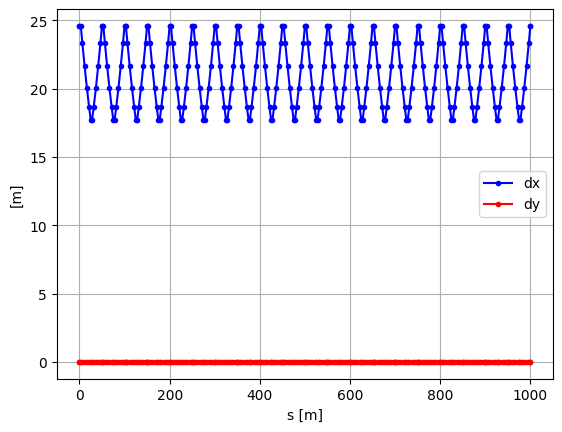

In [425]:
def plot_me(myTwiss):
    plt.plot(myTwiss.s,myTwiss.betx,'.-b', label='betx')
    plt.plot(myTwiss.s,myTwiss.bety,'.-r', label='bety')
    plt.ylabel('[m]')
    plt.xlabel('s [m]')
    plt.grid()
    plt.legend()

    plt.figure()
    plt.plot(myTwiss.s,myTwiss.alfx,'.-b', label='alfx')
    plt.plot(myTwiss.s,myTwiss.alfy,'.-r', label='alfx')
    plt.xlabel('s [m]')
    plt.ylabel('')
    plt.grid()
    plt.legend()

    plt.figure()
    plt.plot(myTwiss.s,myTwiss.mux,'.-b', label='mux')
    plt.plot(myTwiss.s,myTwiss.muy,'.-r', label='muy')
    plt.xlabel('s [m]')
    plt.ylabel('2pi')
    plt.grid()
    plt.legend()

    plt.figure()
    plt.plot(myTwiss.s,myTwiss.dx,'.-b', label='dx')
    plt.plot(myTwiss.s,myTwiss.dy,'.-r', label='dy')
    plt.xlabel('s [m]')
    plt.ylabel('[m]')
    plt.grid()
    plt.legend()
plot_me(myTwiss)

### Can we inject a dipolar error to the machine to see something more interesting?

To do this we create a thin xt.Multipole element with a defined dipole coefficient. We make a copy of our original line and use the line.insert_element method to install the thin dipole kick into the line. 

In [451]:
env.vars['kick_strength'] = 0.0002
kick = env.new('kick', xt.Multipole, knl = ['kick_strength'], length = 0, order = 0)
line2 = env.new('line2', line)
line2.insert_element(kick, index = 'mq.f.cell_0.line2')
line2.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,_start_point.line2,False,False,None,False,Marker(_dummy=np.int64(0))
1,0.0,Multipole,kick,False,False,None,False,"Multipole(_order=np.int64(0), inv_factorial_or..."
2,0.0,Quadrupole,mq.f.cell_0.line2,True,False,None,False,"Quadrupole(k1=0.0098, k1s=0, length=3, num_mul..."
3,3.0,Drift,drift_1.cell_0.line2,True,False,None,False,Drift(length=3.5)
4,6.5,Bend,mb.cell_0.line2,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
...,...,...,...,...,...,...,...,...
258,986.5,Drift,drift_5.cell_19.line2,True,False,None,False,Drift(length=5)
259,991.5,Bend,mb.cell_19.line2,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
260,996.5,Drift,drift_6.cell_19.line2,True,False,None,False,Drift(length=3.5)
261,1000.0,Marker,marker_end.cell_19.line2,False,False,None,False,Marker(_dummy=np.int64(0))


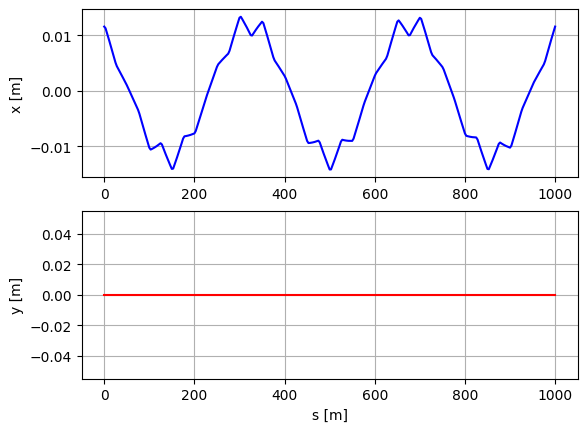

In [452]:
myTwissNew = line2.twiss(method = '4d')
plt.subplot(211)
plt.plot(myTwissNew.s,myTwissNew.x,'b',label='x')
plt.ylabel('x [m]')
plt.grid()

plt.subplot(212)
plt.plot(myTwissNew.s,myTwissNew.y,'r',label='y')
plt.xlabel('s [m]')
plt.ylabel('y [m]')
plt.grid()

Please compare the previous plot with the closed form formula (see Eq. 9 in pag.55/75 of https://indico.cern.ch/event/1380440/contributions/6176021/attachments/2964454/5215010/IntroductionOpticsDesign.pdf), 
$$x_{CO}(s)=\frac{\sqrt{\beta_x(s)\beta_x(s_0)}}{2 \sin(\pi Q_x) } \theta_0 \cos(\phi - \pi Q_x),$$
where $\phi$ (>0) is the phase advance from $s_0$ (position of the $\theta_0$ kick) to the $s$.

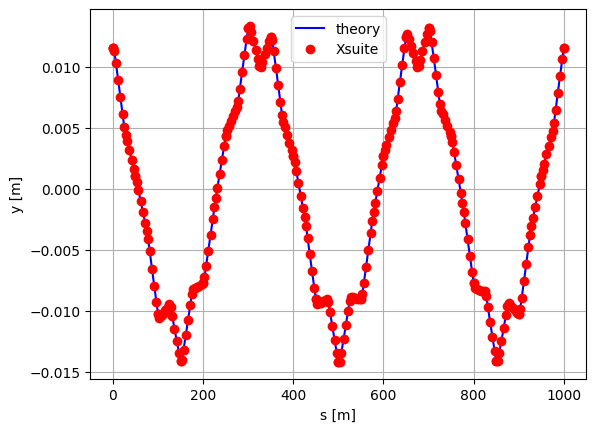

In [453]:
x=-np.sqrt(myTwissNew['betx']*myTwissNew['betx'][0])/2/np.sin(np.pi*myTwissNew['mux'][-1])*0.0002*np.cos(myTwissNew['mux']*2*np.pi-np.pi*myTwissNew['mux'][-1])
plt.plot(myTwissNew['s'],x,'b',label='theory')
plt.plot(myTwissNew['s'],myTwissNew['x'],'or',label='Xsuite')
plt.xlabel('s [m]')
plt.ylabel('y [m]')
plt.grid()
plt.legend(loc='best')

#### What is the dispersive contribution of the kick?

In [454]:
env.vars['kick_strength'] = 0
myTwissRef = line2.twiss(method = '4d')

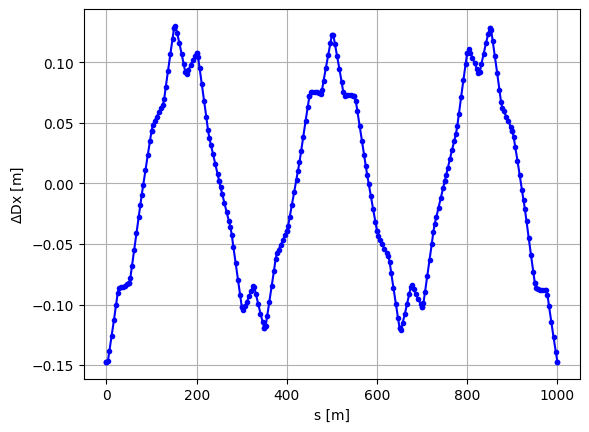

In [455]:
plt.plot(myTwissNew['s'],myTwissNew['dx']-myTwissRef['dx'],'.-b')
plt.xlabel('s [m]')
plt.ylabel(r'$\Delta$Dx [m]')
plt.grid()

## What if we have a coupling error as well?

In [481]:
env.vars['kick_strength'] = 0.0002
env.vars['kskew'] = 0.0004
env.new('skew_quad', xt.Multipole, ksl = [0, 'kskew'])

'skew_quad'

In [482]:
line2.discard_tracker()
line2.insert_element('skew_quad', index = 'mq.f.cell_0.line2')

The horizontal kick now affects the vertical plane! 

## What is the effect of the skew coupling on our optics?

Let's compute the one-turn map...

In [483]:
twSkew = line2.twiss4d()
rmat = twSkew.get_R_matrix('_start_point.line2', '_end_point')
rmat4 = rmat[:4,:4] 
display(rmat4)

array([[ 1.45891909e+00, -7.73019431e+01, -6.18426593e-02,
        -4.58215211e-05],
       [ 2.79697185e-02, -7.96557927e-01, -6.37241493e-04,
        -9.31563301e-08],
       [ 3.89681513e-02, -4.73016788e-05,  4.71611031e-01,
         4.87085524e+01],
       [-8.06438697e-04,  3.77274881e-07, -3.02904639e-02,
        -1.00804391e+00]])

In introductory accelerator physics courses, it is common to compute the fractional horizontal tune from the trace of the horizontal transfer matrix as $$
q_x = arccos(Tr[M_x])/2\pi
$$

In [484]:
rmat2 = rmat[:2,:2] 
qx = np.acos(np.trace(rmat2)/2)/(2*np.pi)
qx

np.float64(0.1962765346576706)

However, let us try outputting the horizontal tune directly from the Xsuite Twiss...

In [485]:
np.abs(np.round(twSkew.qx)-twSkew.qx)

np.float64(0.19644632608451262)

These values no longer agree past the third decimal point! Why is this?

What is the meaning of horizontal tune in a coupled system?

In general, the fractional tunes of any periodic system can be computed from the eigenvalues of its transfer matrix. They are given by the argument of the complex eigenvalues normalised by 2pi.

In [486]:
eigtunes = np.angle(np.linalg.eig(rmat4)[0])/np.pi/2
eigtunes

array([ 0.19644633, -0.19644633,  0.29305081, -0.29305081])

This matches the value computed from Xsuite... -- a first taste of coupled dynamics. 

In [480]:
xtunes = [np.abs(twSkew.qx-np.round(twSkew.qx)), np.abs(twSkew.qy-np.round(twSkew.qy))]
xtunes

[np.float64(0.1963189433373378), np.float64(0.29317557818922024)]

## Beam envelope

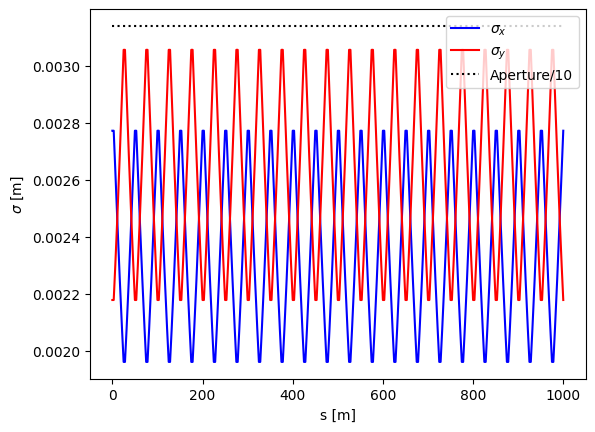

In [487]:
p_GeV_c=20.
E0_GeV=0.938 # approx
Etot_GeV=np.sqrt(p_GeV_c**2+E0_GeV**2)
Ekin_GeV=Etot_GeV-E0_GeV
aperture_limit=0.0314/10; #divide by 10 for 10 sigma limit
emittance_normalized_x=emittance_normalized_y=2.e-6

gamma=Etot_GeV/E0_GeV
beta=np.sqrt(1-1/gamma**2)
betagamma=beta*gamma

myTwiss['sigmax']=np.sqrt(myTwiss.betx*emittance_normalized_x/betagamma)
myTwiss['sigmay']=np.sqrt(myTwiss.bety*emittance_normalized_y/betagamma)

plt.plot(myTwiss.s,myTwiss.sigmax,'b', label = r'$\sigma_x$')
plt.plot(myTwiss.s,myTwiss.sigmay,'r', label = r'$\sigma_y$')

plt.plot(myTwiss.s, myTwiss.s*0+aperture_limit,'k:', label = 'Aperture/10')
plt.xlabel('s [m]')
plt.ylabel(r'$\sigma$ [m]');

plt.legend(loc=1)

## Dispersion contribution to the envelope

Just having a small beta-function is not necessarily sufficient to keep the whole beam in the aperture. We also need to consider the dispersion and how it relates to the momentum spread of the beam: let us assume $\Delta P/P_0 = 10^{-3}$.

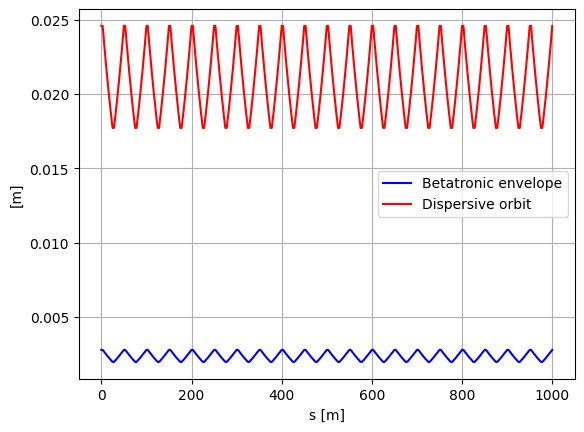

In [488]:
plt.plot(myTwiss.s,myTwiss.sigmax,'b', label='Betatronic envelope')
plt.plot(myTwiss.s,myTwiss.dx*1e-3,'r', label='Dispersive orbit')
plt.xlabel('s [m]')
plt.ylabel('[m]');
plt.grid(True)
plt.legend(loc='best')

## Tracking

Can you compute the particle trajectories if you start particles (at s=0) with offsets on the order of 1 mm (x'=0)?

In [492]:
line.build_tracker() #generate tracker for original line (no dipolar kick!)
particles = line.build_particles(
                        x=[0.001, -0.0005, 0.00002]) #create single particle with 1mm offset from closed orbit

The line already has an associated tracker


In [493]:
n_turns = 1
line.track(particles, num_turns=n_turns,
              turn_by_turn_monitor='ONE_TURN_EBE') #track particle for 1 turn.
#Flag 'ONE_TURN_EBE' tells Xsuite to save particle data at each element for one turn
#Normally 'True' flag saves data once per turn only. 'False' flag does tracking for n_turns without saving intermediate steps

Text(0, 0.5, 'x [m]')

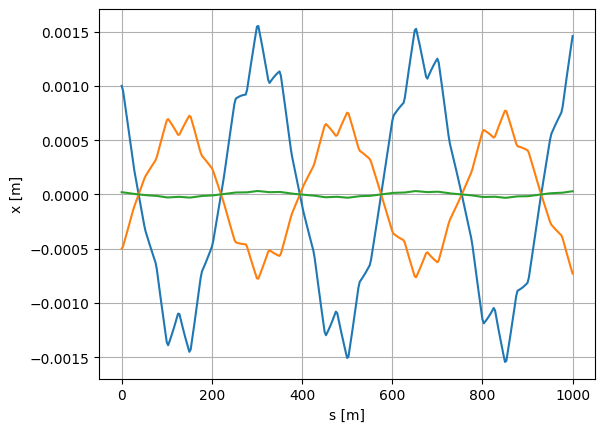

In [494]:
plt.plot(line.record_last_track.s.T, line.record_last_track.x.T)
plt.grid()
plt.xlabel('s [m]')
plt.ylabel('x [m]')

## Courant-Snyder invariant 

The C-S invariant should be an invariant of the motion -- is it? 

(0.0, 1000.0)

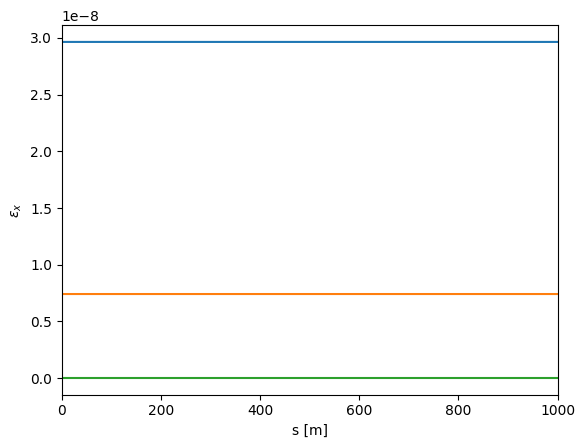

In [501]:
part = line.record_last_track
cs = myTwiss.gamx*part.x**2 + 2*myTwiss.alfx*part.px*part.x + myTwiss.betx*part.px**2
plt.plot(part.s.T, cs.T)
plt.ylabel(r'$\epsilon_x$')
plt.xlabel('s [m]')
plt.xlim(0, line.get_length())

As expected, the Courant-Snyder invariant does not change throughout the cell. 

## Can you plot the normalized $x(s)$ vs $\mu_x(s)$?

Remember that $$\bar{P}=\begin{pmatrix}
    \sqrt{\beta} &        0\\\\
    -\frac{\alpha}{\sqrt{\beta}} &  \frac{1}{\sqrt{\beta}} \end{pmatrix}=
    \begin{pmatrix}
    \sqrt{\beta} &        0\\\\
    0 &  \frac{1}{\sqrt{\beta}}
    \end{pmatrix}
    \begin{pmatrix}
    1 &        0\\\\
    \frac{\alpha}{\sqrt{\beta}} &  1
    \end{pmatrix},$$
and that to transform to normalised space $$
    \bar{X}=\bar{P}^{-1} X.$$

In other words, you need to divide $x(s)$ by $\sqrt{\beta(s)}$.

3


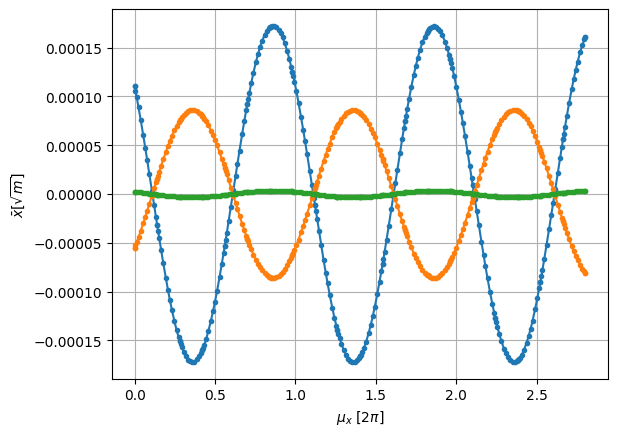

In [516]:
xs = line.record_last_track.x.T
n_parts = xs.shape[1]
print(n_parts)
betxs = np.repeat(myTwiss.betx[:, np.newaxis], n_parts, axis=1)
normx = xs/np.sqrt(betxs)
muxs = np.repeat(normx, xs.shape[1], axis = 1)

plt.plot(myTwiss['mux'],normx,'.-')

plt.grid()
plt.xlabel(r'$\mu_x$ [2$\pi$]')
plt.ylabel(r'$\bar{x}$[$\sqrt{m}$]');

Particles trace out sinusoidal oscillations in normalised phase space. 

## Can you determine the machine tune by a numerical experiment (tracking)?

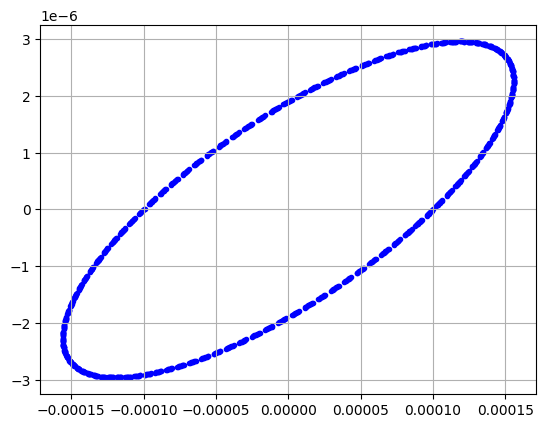

In [517]:
particles = line.build_particles(
                        x=0.0001) #generate single particle

n_turns = 2**10
line.track(particles, num_turns=n_turns,
              turn_by_turn_monitor=True) #track for large number of turns and save position at same point each turn
myParticle = line.record_last_track
plt.scatter(myParticle.x.T, myParticle.px.T, marker = '.', color = 'b') #plot phase space ellipse from tracking over successive turns
plt.grid()

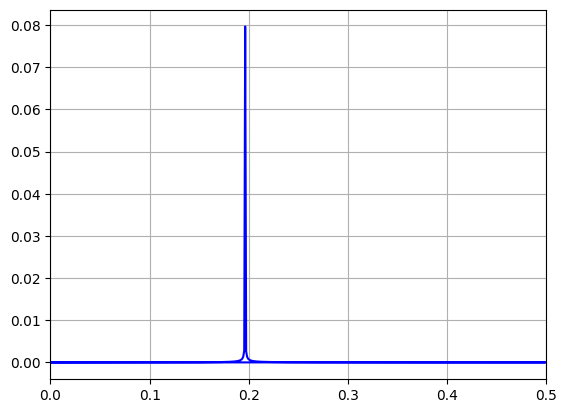

In [518]:
myAmplitude=np.abs(np.fft.fft(myParticle.x.flatten())); #use Fast Fourier Transform (FFT) to measure tune
myTunes=np.fft.fftfreq(n_turns)

plt.plot(myTunes,myAmplitude, 'b')
plt.xlim([0,0.5])
plt.grid()

In [519]:
myTunes[np.argmax(myAmplitude)] #select maximum

np.float64(0.1962890625)

In [520]:
#to compare with
np.round(myTwiss.qx)-myTwiss.qx #subtract integer part of tune

np.float64(0.1962557258086588)

In general we can use in our frequency analysis the fact that we expect to have well separated harmonic oscillations and they are time-constant.

The NAFF algorithm of J. Laskar can be used as an alternative for the FFT. A python library with an implementation of the algorithm is found in https://pypi.org/project/nafflib/ - how does it compare to the FFT for tune computation?

In [521]:
import nafflib
import numpy as np

t = np.linspace(1, 1024, num=1024, endpoint=True)
signal = myParticle.x.flatten()
# outputs an array of arrays for each frequency. Each sub-array includes:
# [order of harmonic, frequency, Amplitude, Re{Amplitude}, Im{Amplitude]

myListNAFF=[]
myListFFT=[]
for i in np.arange(10,1025):
    myListNAFF.append(nafflib.tune(signal[0:i]))
    myAmplitude=np.abs(np.fft.fft(signal[0:i]));
    myTunes=np.linspace(0,1,i)
    myListFFT.append(np.min(myTunes[myAmplitude==np.max(myAmplitude)]))

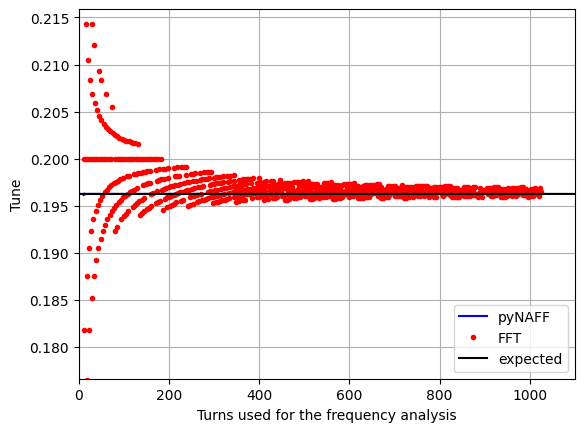

In [522]:
Qx = np.round(myTwiss.qx)-myTwiss.qx
myFig=plt.figure()
plt.plot(np.arange(10,1025),myListNAFF,'b',label='pyNAFF')
plt.plot(np.arange(10,1025),myListFFT,'.r',label='FFT')
plt.plot(np.arange(0,2000),3-myTwiss.qx+np.arange(0,2000)*0,'k',label='expected')
plt.grid()
plt.ylim(Qx*0.9,Qx*1.1)
plt.xlim(0,1100)
plt.xlabel('Turns used for the frequency analysis')
plt.ylabel('Tune')
plt.legend(loc='best')

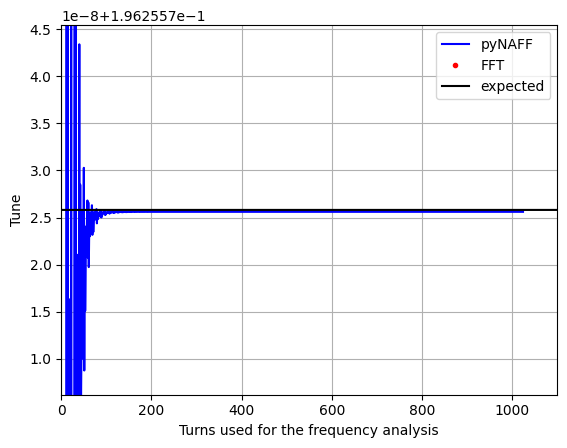

In [523]:
myFig.gca().set_ylim(Qx*0.9999999,Qx*1.0000001)
display(myFig)